**Main imports**

In [2]:
# imports
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython import display as disp
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

**Batch Size**
A batch size of 512 is used

In [ ]:
BATCH_SIZE = 512

**Load Data** \
<u> Key Augmentation Steps Include: </u>
- Random Crop
- Random Horizontal Flip
- Random Rotation
- Color Jitter
- Randomly Applied Gaussain Blur
- Normalisation
- Random Erasing

In [ ]:
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

class_names = ['apple','aquarium_fish','baby','bear','beaver','bed','bee','beetle','bicycle','bottle','bowl','boy','bridge','bus','butterfly','camel','can','castle','caterpillar','cattle','chair','chimpanzee','clock','cloud','cockroach','couch','crab','crocodile','cup','dinosaur','dolphin','elephant','flatfish','forest','fox','girl','hamster','house','kangaroo','computer_keyboard','lamp','lawn_mower','leopard','lion','lizard','lobster','man','maple_tree','motorcycle','mountain','mouse','mushroom','oak_tree','orange','orchid','otter','palm_tree','pear','pickup_truck','pine_tree','plain','plate','poppy','porcupine','possum','rabbit','raccoon','ray','road','rocket','rose','sea','seal','shark','shrew','skunk','skyscraper','snail','snake','spider','squirrel','streetcar','sunflower','sweet_pepper','table','tank','telephone','television','tiger','tractor','train','trout','tulip','turtle','wardrobe','whale','willow_tree','wolf','woman','worm',]


transform_augmented = transforms.Compose([
    transforms.RandomCrop(32, padding=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.2, 0.2, 0.2]),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15)),
])

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=True, download=True,
                                  transform=transform_augmented),
    batch_size=BATCH_SIZE, drop_last=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=False, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])),
    batch_size=BATCH_SIZE, drop_last=True)

train_iterator = iter(cycle(train_loader))
test_iterator = iter(cycle(test_loader))

print(f'> Size of training dataset {len(train_loader.dataset)}')
print(f'> Size of test dataset {len(test_loader.dataset)}')

100%|██████████| 169001437/169001437 [00:03<00:00, 52909284.06it/s]


Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified
> Size of training dataset 50000
> Size of test dataset 10000


**View some of the test dataset**

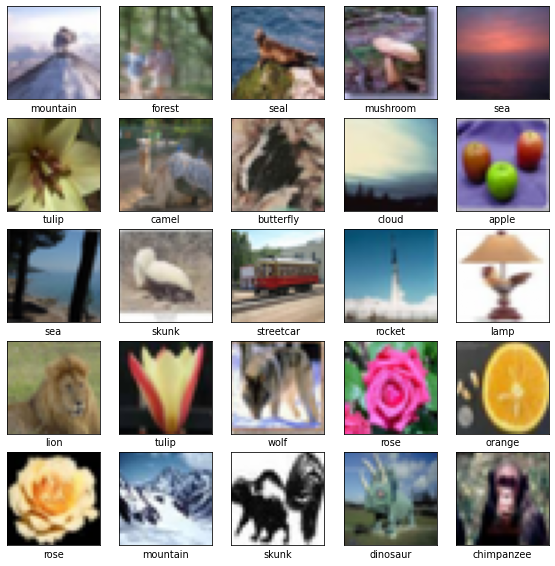

In [ ]:
plt.rcParams['figure.dpi'] = 70
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    img = test_loader.dataset[i][0].numpy().transpose(1, 2, 0)
    plt.imshow(img)
    plt.xlabel(class_names[test_loader.dataset[i][1]])
plt.show()

**Depthwise Seperable Convolution Layer**

In [3]:
class DepthwiseSeparableConv(nn.Module):
    'https://arxiv.org/abs/1704.04861'
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size,
                                   stride=stride, padding=padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

**Classifier Architechure** \
<u>Key Components</u>
- Composed of standard Convolutional 2D (Conv2d) layers and Depthwise Separable Layers.
- Employs a dropout rate of 10%, applied midway through the forward propagation method.
- Utilizes the Rectified Linear Unit (ReLU) as the activation function.
- Bottleneck Structure - The model significantly expands in width before rapidly narrowing.


In [ ]:

  class Classifier(nn.Module):
      def __init__(self, ch_in, n_classes):
          super(Classifier, self).__init__()
          self.dropout = nn.Dropout(p=0.1)
          self.activation = nn.ReLU()

          self.conv1 = nn.Conv2d(ch_in, 32, kernel_size=3, stride=1, padding=1)
          self.bn1 = nn.BatchNorm2d(32)
          self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
          self.bn2 = nn.BatchNorm2d(64)

          self.conv3 = DepthwiseSeparableConv(64, 120, kernel_size=3, padding=1)
          self.bn3 = nn.BatchNorm2d(120)

          self.conv4 = DepthwiseSeparableConv(120, 220, kernel_size=3, padding=1)
          self.bn4 = nn.BatchNorm2d(220)

          self.conv5 = DepthwiseSeparableConv(220, 120, kernel_size=3, padding=1)
          self.bn5 = nn.BatchNorm2d(120)

          self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
          self.global_pool = nn.AdaptiveAvgPool2d(1)
          self.fc = nn.Linear(120, n_classes)

      def forward(self, x):
          x = self.activation(self.bn1(self.conv1(x)))
          x = self.pool(x)
          x = self.activation(self.bn2(self.conv2(x)))
          x = self.pool(x)
          x = self.dropout(x)
          x = self.activation(self.bn3(self.conv3(x)))
          x = self.activation(self.bn4(self.conv4(x)))
          x = self.activation(self.bn5(self.conv5(x)))
          x = self.global_pool(x)
          x = torch.flatten(x, 1)
          x = self.fc(x)
          return x


> Number of parameters 97584


**Paramaters**

In [ ]:
# hyperparameters
params = {
    'n_channels': 3,  # number of channels
    'n_classes':  100, # number of classes for CIFAR-100
}

# define N
N = Classifier(ch_in=params['n_channels'],n_classes=params['n_classes']).cuda()

# print the number of parameters - this should be included in your report
print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(N.parameters()))}')

if len(torch.nn.utils.parameters_to_vector(N.parameters())) > 100000:
    print("> Warning: you have gone over your parameter budget and will have a grade penalty!")

# initialise the optimiser
optimiser = torch.optim.Adam(N.parameters(), lr=0.001)
# scheduler (StepLR used)
scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=1000, gamma=0.2)

plot_data = []
steps = 0

**Main training and testing loop**

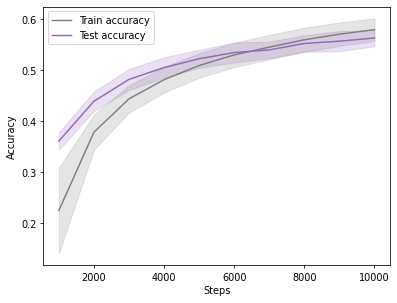

In [ ]:
# keep within our optimisation step budget
while (steps < 10000):

    # arrays for metrics
    train_loss_arr = np.zeros(0)
    train_acc_arr = np.zeros(0)
    test_acc_arr = np.zeros(0)

    # iterate through some of the train dateset
    for i in range(1000):
        x,t = next(train_iterator)
        x,t = x.to(device), t.to(device)
        optimiser.zero_grad()
        p = N(x)
        pred = p.argmax(dim=1, keepdim=True)
        loss = torch.nn.functional.cross_entropy(p, t)
        loss.backward()
        optimiser.step()
        steps += 1

        train_loss_arr = np.append(train_loss_arr, loss.cpu().data)
        train_acc_arr = np.append(train_acc_arr, pred.data.eq(t.view_as(pred)).float().mean().item())

    scheduler.step()

    # iterate over the entire test dataset
    for x,t in test_loader:
        x,t = x.to(device), t.to(device)
        p = N(x)
        loss = torch.nn.functional.cross_entropy(p, t)
        pred = p.argmax(dim=1, keepdim=True)
        test_acc_arr = np.append(test_acc_arr, pred.data.eq(t.view_as(pred)).float().mean().item())

    # plot your accuracy graph - add a graph like this in your final report
    plot_data.append([steps, np.array(train_acc_arr).mean(), np.array(train_acc_arr).std(), np.array(test_acc_arr).mean(), np.array(test_acc_arr).std()])
    reward_list = []
    plt.plot([x[0] for x in plot_data], [x[1] for x in plot_data], '-', color='tab:grey', label="Train accuracy")
    plt.fill_between([x[0] for x in plot_data], [x[1]-x[2] for x in plot_data], [x[1]+x[2] for x in plot_data], alpha=0.2, color='tab:grey')
    plt.plot([x[0] for x in plot_data], [x[3] for x in plot_data], '-', color='tab:purple', label="Test accuracy")
    plt.fill_between([x[0] for x in plot_data], [x[3]-x[4] for x in plot_data], [x[3]+x[4] for x in plot_data], alpha=0.2, color='tab:purple')
    plt.xlabel('Steps')
    plt.ylabel('Accuracy')
    plt.legend(loc="upper left")
    plt.show()
    disp.clear_output(wait=True)

**Loss / Accuracy Data**

In [ ]:
# print your loss and accuracy data - include this in the final report
print('steps: {:.2f}, train loss: {:.3f}, train acc: {:.3f}±{:.3f}, test acc: {:.3f}±{:.3f}'.format(steps, train_loss_arr.mean(),train_acc_arr.mean(),train_acc_arr.std(),test_acc_arr.mean(),test_acc_arr.std()))

steps: 10000.00, train loss: 1.507, train acc: 0.579±0.022, test acc: 0.563±0.016


**Inference on dataset**

This is useful for analysis but is entirely optional

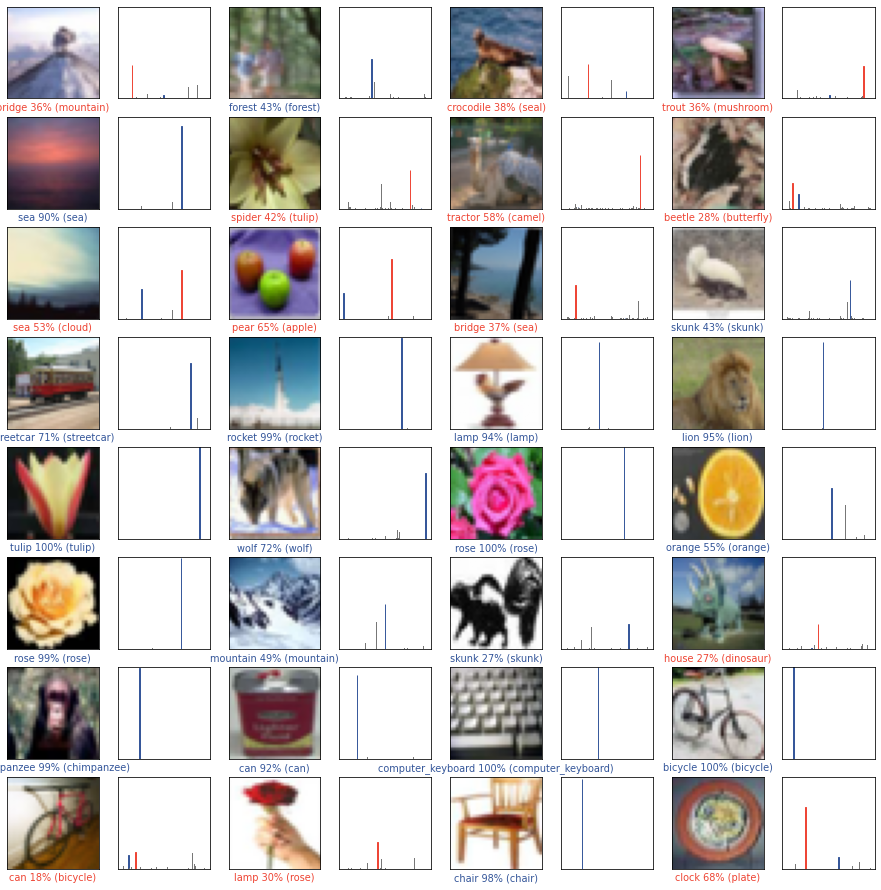

In [ ]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)

    predicted_label = np.argmax(predictions_array)
    color = '#335599' if predicted_label == true_label else '#ee4433'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                  100*np.max(predictions_array),
                                  class_names[true_label]),
                                  color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(100), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('#ee4433')
    thisplot[true_label].set_color('#335599')

test_images, test_labels = next(test_iterator)
test_images, test_labels = test_images.to(device), test_labels.to(device)
test_preds = torch.softmax(N(test_images), dim=1).data.cpu().numpy()
num_rows = 8
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, test_preds, test_labels.cpu().numpy(), test_images.cpu().numpy()) # Used .numpy() here
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, test_preds, test_labels.cpu().numpy())